# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 28 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [32]:
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

In [33]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        components_: integer
            number of normal distributions
        pi_: np.array
            array containing probabilities to belong to a given class
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.components_ = k
        self.pi_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
        
    def fit(self, X, pi_=None, mu_=None, Sigma_=None, max_iter=50):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        def compute_condition_prob_matrix(X, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            # First compute the matrix of size (n,k) containing density of each normal applied to each point
            f_ik = np.array([multivariate_normal.pdf(X,mean=mu[k],cov=Sigma[k], allow_singular=True) for k in range(len(Sigma))]).T
            # Sum with regards to the components
            sum_f_ik = np.expand_dims(np.sum(f_ik, axis=1), axis=1)
            # Return the division
            return f_ik / sum_f_ik
        
        # First we must instantiate parameters 
        # We apply a prior k_means algorithm to generate consistent initial centroids, as in k-means, we assume
        # prior probabilities to be uniform over the cluster classes.
        if pi_ is None:
            # Prior probabilites are uniform
            pi_ = np.ones((self.components_,)) / self.components_
        else:
            self.pi_ = pi_
            
        # Run k-means over data
        kmeans = KMeans(n_clusters=self.components_).fit(X)
        
        if mu_ is None:
            # Take k-means values as initial centroids
            self.mu_ = kmeans.cluster_centers_
        else:
            self.mu_ = mu_
            
        if Sigma_ is None:
            # Initialize covariance matrices to identity
            self.Sigma_ = np.array([np.identity(X.shape[1]) for i in range(self.components_)])
        else:
            self.Sigma_ = Sigma_
        
        # Initialize labels_
        self.cond_prob_ = compute_condition_prob_matrix(X,self.mu_,self.Sigma_)
        self.labels_ = np.argmax(self.cond_prob_, axis=1)
        
        # Initialize convergence parameters
        converge = False
        iter_ = 1
        
        while not converge and iter_ <= max_iter:
            
            # Update parameters
            # Prior
            self.pi_ = np.sum(self.cond_prob_, axis=0) / X.shape[0]
            
            # Mean
            X_probs = np.array([[X[i,:] * self.cond_prob_[i,k] for k in range(self.components_)] for i in range(X.shape[0])])
            X_probs_sum = np.sum(X_probs, axis=0)
            self.mu_ = X_probs_sum / (np.expand_dims(pi_, axis=1) * X.shape[0])
            
            # Covariance
            X_minus_mu_square = np.array([[self.cond_prob_[i,l] * np.matmul(np.expand_dims((X[i,:]-self.mu_[l,:]), axis=1),np.expand_dims((X[i,:]-self.mu_[l,:]), axis=1).T) for i in range(X.shape[0])] for l in range(self.components_)])
            X_minus_mu_square_sum = np.sum(X_minus_mu_square, axis=1)
            self.Sigma_ = X_minus_mu_square_sum / (np.expand_dims(pi_, axis=(1,2)) * X.shape[0])
            
            # Compute new conditional probability matrix and labels
            self.cond_prob_ = compute_condition_prob_matrix(X,self.mu_,self.Sigma_)
            labels_ = np.argmax(self.cond_prob_, axis=1)
            
            # Check for convergence
            if np.array_equal(labels_, self.labels_):
                # If labels haven't changed during iteration, convergence has been met
                converge = True
            
            # Update labels_ value
            self.labels_ = labels_
            
            # Increment iteration
            iter_ += 1
    
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        def compute_condition_prob_matrix(X, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            # First compute the matrix of size (n,k) containing density of each normal applied to each point
            f_ik = np.array([multivariate_normal.pdf(X,mean=mu[k],cov=Sigma[k], allow_singular=True) for k in range(len(Sigma))]).T
            # Sum with regards to the components
            sum_f_ik = np.expand_dims(np.sum(f_ik, axis=1), axis=1)
            # Return the division
            return f_ik / sum_f_ik
        # TODO
        # We compute the conditional probability matrix and take the argmax as label
        cond_prob = compute_condition_prob_matrix(X,self.mu_,self.Sigma_)
        return np.argmax(cond_prob, axis=1)
        
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        def compute_condition_prob_matrix(X, mu, Sigma):
            '''Compute the conditional probability matrix 
            shape: (n, K)
            '''
            # First compute the matrix of size (n,k) containing density of each normal applied to each point
            f_ik = np.array([multivariate_normal.pdf(X,mean=mu[k],cov=Sigma[k], allow_singular=True) for k in range(len(Sigma))]).T
            # Sum with regards to the components
            sum_f_ik = np.expand_dims(np.sum(f_ik, axis=1), axis=1)
            # Return the division
            return f_ik / sum_f_ik
        # TODO
        # We compute the conditional probability matrix
        return compute_condition_prob_matrix(X,self.mu_,self.Sigma_)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

This function generates a dataset obtained from 3 different multivariate normal distributions whose parameters are generated randomly. We run this function several times until finding satisfying parameters.

In [4]:
def generate_random_points(N, K, p):
    all_mu      = []
    all_sigma   = []
    priors      = []
    data_points = []
    labels      = []
    
    for k in range(K):
        Z          = np.random.normal(0, 1, p)
        sigma_diag = np.diag(10*np.random.rand(p))
        u, s, vh   = np.linalg.svd(np.random.randn(p, p), full_matrices=False)
        mat_rot    = np.dot(u, vh)
        sigma      = np.dot(mat_rot, np.dot(sigma_diag, mat_rot.T))
        priors.append(np.random.rand())
        all_mu.append(2*Z / np.sqrt(sum(Z**2))) # random point on the unit m-sphere
        all_sigma.append(sigma * m / np.matrix.trace(sigma))
    priors            = priors / np.sum(priors)
    priors_cumulative = [sum(priors[:i]) for i in range(len(priors))] + [1]
    for n in range(N):
        rnd = np.random.rand()
        for k in range(K):
            if priors_cumulative[k] < rnd < priors_cumulative[k+1]:
                data_points.append(np.random.multivariate_normal(all_mu[k], all_sigma[k]))
                labels.append(k)
    
    return data_points, labels, priors, all_mu, all_sigma

The following parameters offer a satisfying distribution.

In [5]:
N = 3000
K = 3
m = 2

In [6]:
mu = np.array([[ 1.97853847,  0.29220802],
                [ 1.92894267, -0.52837502],
                [ 0.8393801 , -1.81533497]])

Sigma = np.array([[[ 0.74340333,  0.28804857],
                    [ 0.28804857,  1.25659667]],

                    [[ 1.93345954,  0.22201081],
                    [ 0.22201081,  0.06654046]],

                    [[ 1.04537834, -0.4132763 ],
                    [-0.4132763 ,  0.95462166]]])

In [7]:
# Generate data points with regards to mu and Sigma vlaues

data_points = []

prior = np.random.rand(K,)
prior = prior / np.sum(prior)

labels = []

for k in range(K):
    data_points.append(np.random.multivariate_normal(mu[k],Sigma[k],size=int(prior[k]*N)))
    label = [k for i in range(int(prior[k]*N))]
    labels += label
    
data_points = np.vstack(data_points)
labels = np.array(labels)

In [142]:
data_points.shape

(2998, 2)

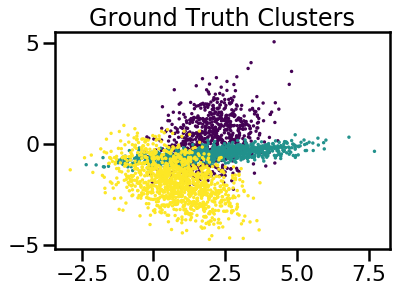

In [143]:
plt.scatter(data_points[:,0], data_points[:,1], s=2., c=labels)
plt.title('Ground Truth Clusters')
plt.show()

First, let us check the k-means performance on clustering this dataset:

In [144]:
from sklearn.cluster import KMeans

In [145]:
kmeans = KMeans(n_clusters=K).fit(data_points)

In [146]:
kmeans_labels = kmeans.labels_

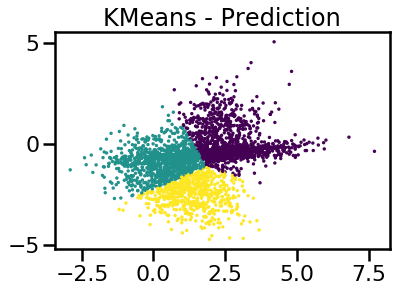

In [147]:
# Plot k-means clusters
plt.figure(figsize=(6,4))
plt.scatter(data_points[:,0],data_points[:,1],s=2.,c=kmeans_labels)
plt.title('KMeans - Prediction')
plt.show()

We than apply our EM algorithm:

In [148]:
gmm = my_GMM(K)
gmm.fit(data_points)

In [151]:
pred_labels = gmm.labels_

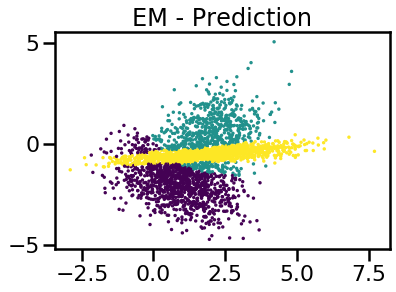

In [152]:
# Plot k-means clusters
plt.figure(figsize=(6,4))
plt.scatter(data_points[:,0],data_points[:,1],s=2.,c=pred_labels)
plt.title('EM - Prediction')
plt.show()

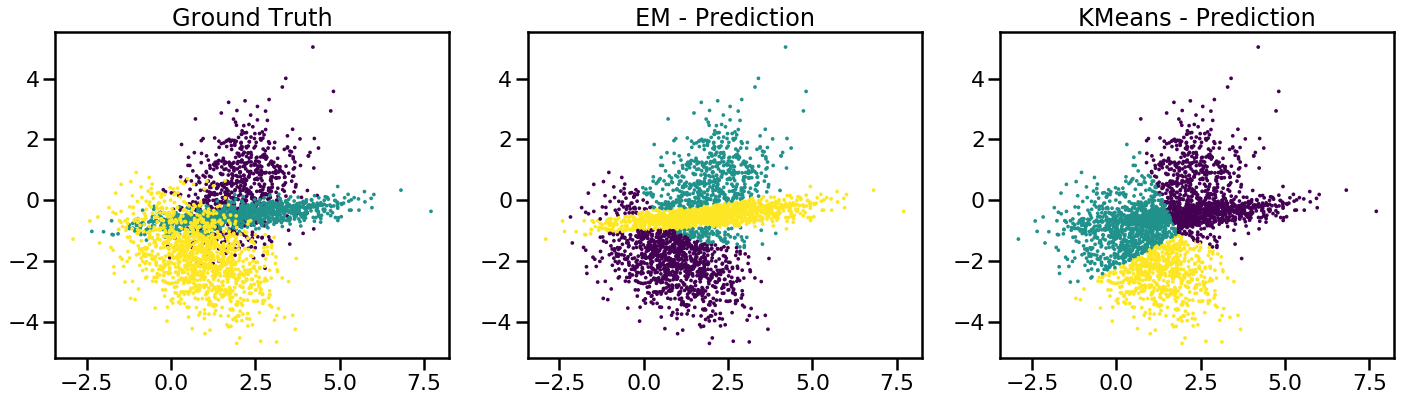

In [156]:
fig,axs = plt.subplots(1,3,figsize=(24,6))

axs[0].scatter(data_points[:,0],data_points[:,1],s=3.,c=labels)
axs[0].set_title('Ground Truth')

axs[1].scatter(data_points[:,0],data_points[:,1],s=3.,c=pred_labels)
axs[1].set_title('EM - Prediction')

axs[2].scatter(data_points[:,0],data_points[:,1],s=3.,c=kmeans_labels)
axs[2].set_title('KMeans - Prediction')

plt.show()

This example shows the power of the EM algorithm over k-means clustering. Indeed, the EM clustering is able to extract precisely three multivariate-gaussian distributions with important overlapping which, by nature, k-means is unable to realize.

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

In [ ]:
# TODO

- Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error 
    - Comparing the parameters

In [ ]:
# TODO

- Implement cross-validation 

In [ ]:
# TODO

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

In [ ]:
# TODO

## Application

You are going to work with the following data:

shape: (1797, 64)


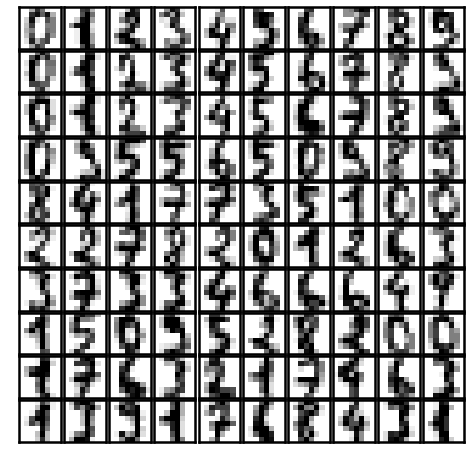

In [8]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [10]:
from sklearn.decomposition import PCA

While applying PCA, we generally attempt to keep between 95 and 99% of the datasets variance. We test both thresholds to define an interval of dimensions.

In [34]:
data, labels = digits.data, digits.target

In [35]:
pca_95 = PCA(n_components=0.95)
pca_95.fit(data)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [36]:
reduced_95 = pca_95.transform(data)

In [37]:
reduced_95.shape

(1797, 29)

In [38]:
pca_99 = PCA(n_components=0.99)
pca_99.fit(data)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
reduced_99 = pca_99.transform(data)

In [40]:
reduced_99.shape

(1797, 41)

In order to keep 95-99% of variance, we must reduce our data in a space of dimension between 29 and 41.

We apply GMM to both datasets of reduced dimension. In this case, the number of clusters is quite direct, as we want to explicit 10 distinct classes of digits:

In [51]:
# Standardizing Data
reduced_95 = (reduced_95 - np.mean(reduced_95)) / np.std(reduced_95)
reduced_99 = (reduced_99 - np.mean(reduced_99)) / np.std(reduced_99)

In [52]:
gmm_95 = my_GMM(10)
gmm_99 = my_GMM(10)

In [53]:
gmm_95.fit(reduced_95)

In [54]:
gmm_99.fit(reduced_99)

In [82]:
# Assigning digit values to each cluster
def assign_vals(cluster_labels, true_labels):
    values = []
    for label in np.unique(cluster_labels):
        true_cluster_vals = true_labels[np.where(cluster_labels == label)[0]]
        labels_in_cluster, count = np.unique(true_cluster_vals, return_counts=True)
        values.append(labels_in_cluster[np.argmax(count)])
    return np.array(values)

# Return predicted label vector
def cluster_label_pred(cluster_labels,assigned_vals):
    labels = assigned_vals[cluster_labels]
    return labels

We apply GMM to reduced datasets in dimensions 29 to 41. We will then assess the best model using a model select approach:

In [89]:
dimensions = np.arange(29,42)

In [90]:
dimensions

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [94]:
# Apply PCA in each of the above dimension and GMM on the reduced dataset
models_labels = []

for dimension in dimensions:
    print("Fitting for dimension {}".format(dimension))
    # Fit PCA
    pca = PCA(n_components=dimension)
    pca.fit(data)
    # Reduce dataset
    reduced_data = pca.transform(data)
    # Standardize data and apply GMM
    reduced_data = (reduced_data - np.mean(reduced_data)) / np.std(reduced_data)
    gmm = my_GMM(10)
    gmm.fit(reduced_data)
    # Assign labels to data according to the computed clusters
    assigned_cluster_vals = assign_vals(gmm.labels_,labels)
    pred_labels = cluster_label_pred(gmm.labels_,assigned_cluster_vals)
    models_labels.append(pred_labels)

Fitting for dimension 29
Fitting for dimension 30
Fitting for dimension 31
Fitting for dimension 32
Fitting for dimension 33
Fitting for dimension 34
Fitting for dimension 35
Fitting for dimension 36
Fitting for dimension 37
Fitting for dimension 38
Fitting for dimension 39
Fitting for dimension 40
Fitting for dimension 41


In [112]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, cohen_kappa_score

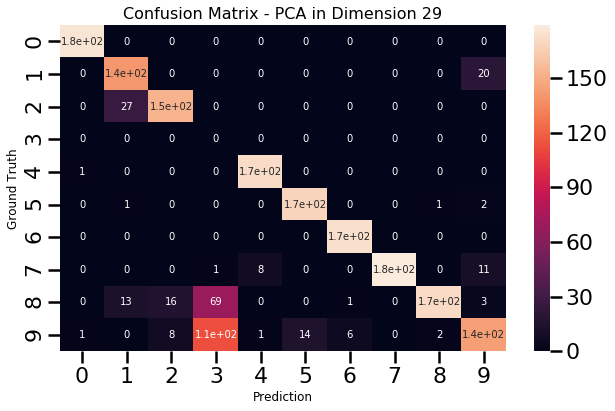

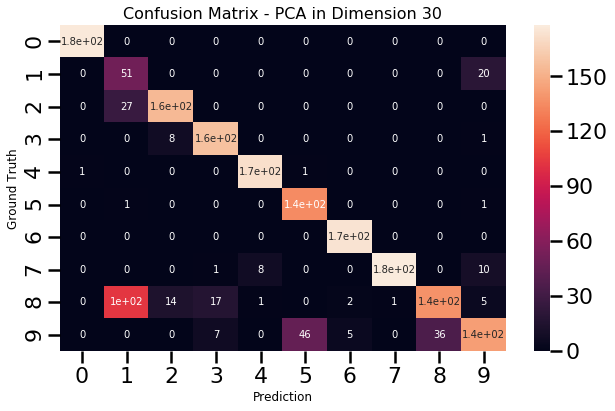

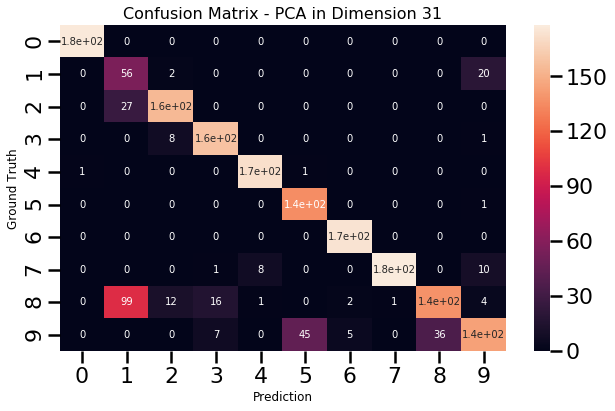

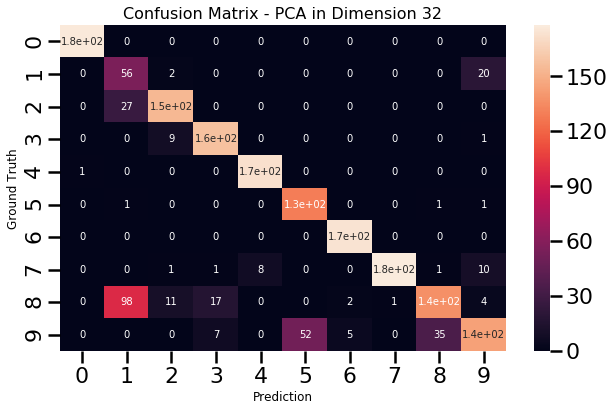

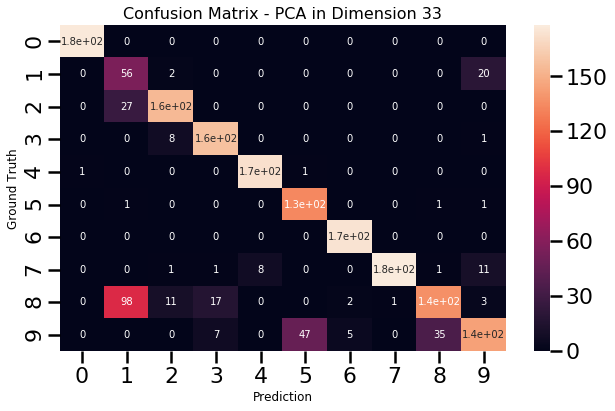

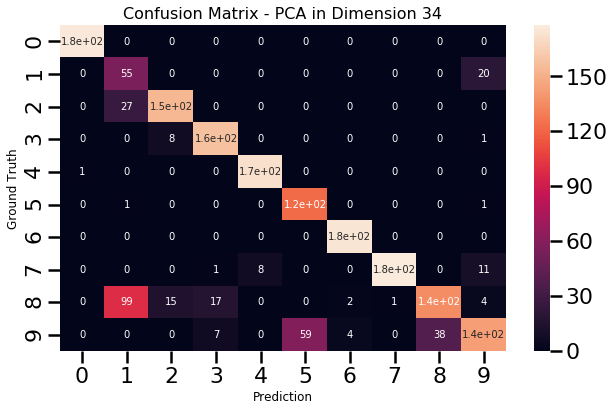

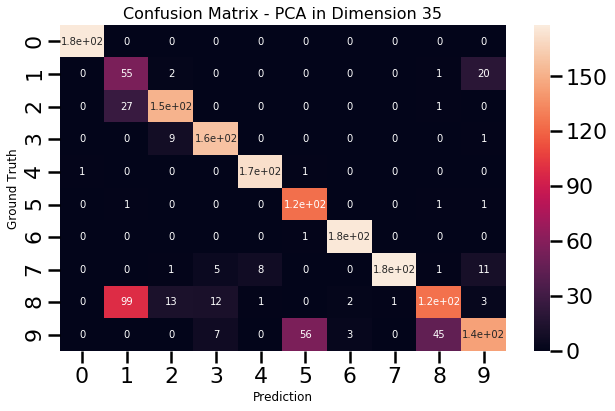

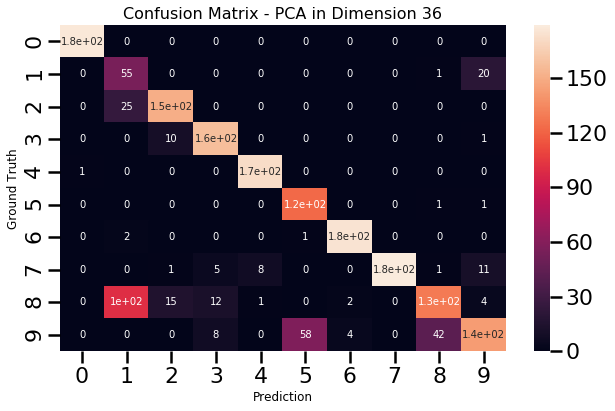

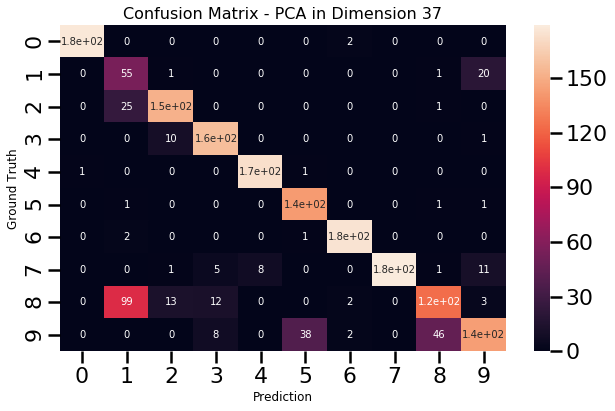

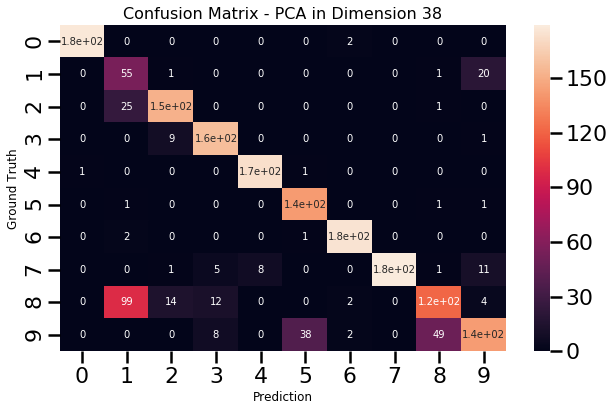

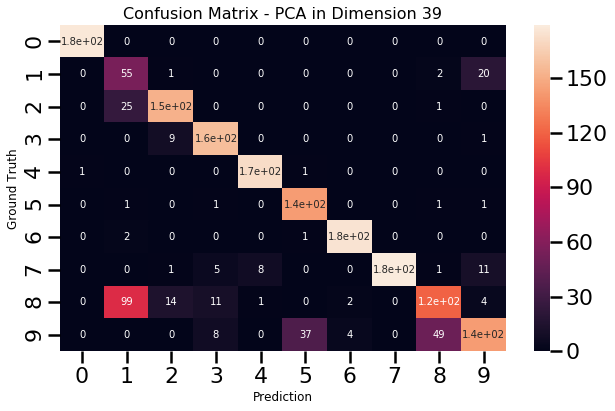

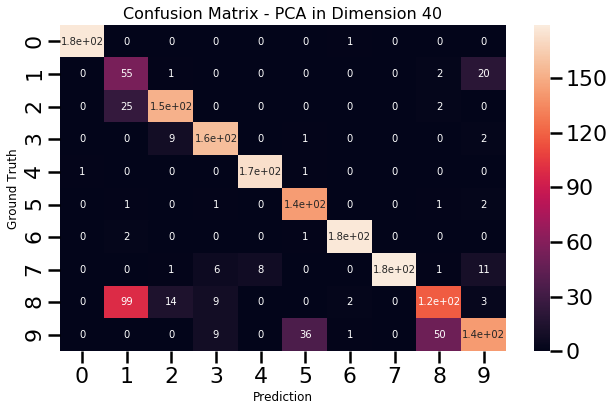

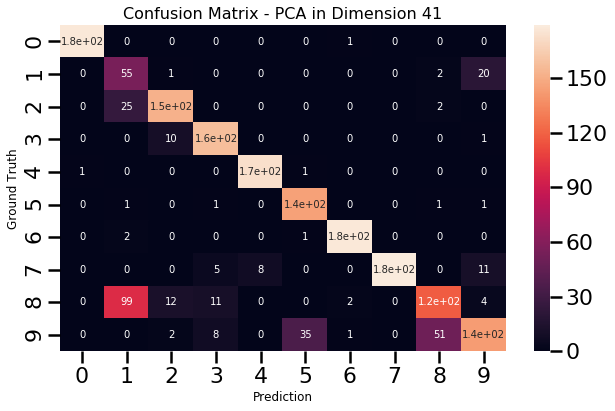

In [109]:
# We plot confusion matrices for each of the computed models
for i in range(len(models_labels)):
    conf = confusion_matrix(models_labels[i], labels)
    plt.figure(figsize=(10,6))
    plt.title("Confusion Matrix - PCA in Dimension {}".format(dimensions[i]), fontsize=16)
    sns.heatmap(conf, annot=True)
    plt.xlabel("Prediction", fontsize=12)
    plt.ylabel("Ground Truth", fontsize=12)
    plt.show()

Model in dimension 29 predicts around half of 9 in 3s, in dimensions 30 and 36, 8s are confused into 1s. Otherwise, it seems complicated to differenciate other models which seem to have similar precisions.

We use Cohen-Kappa scores to evaluate precisions of computed models, this loss seems particularly adapted to our multiclass classification problem.

In [113]:
for i in range(len(models_labels)):
    loss = cohen_kappa_score(models_labels[i],labels)
    print("Cohen-Kappa Score - Model in dimension {}: {}".format(dimensions[i],loss))

Cohen-Kappa Score - Model in dimension 29: 0.8028375234095682
Cohen-Kappa Score - Model in dimension 30: 0.804678414469672
Cohen-Kappa Score - Model in dimension 31: 0.8096190082422893
Cohen-Kappa Score - Model in dimension 32: 0.8046733083584807
Cohen-Kappa Score - Model in dimension 33: 0.8077633915718412
Cohen-Kappa Score - Model in dimension 34: 0.7991134540756553
Cohen-Kappa Score - Model in dimension 35: 0.7929235685550795
Cohen-Kappa Score - Model in dimension 36: 0.7929263465230945
Cohen-Kappa Score - Model in dimension 37: 0.8034282058161855
Cohen-Kappa Score - Model in dimension 38: 0.8009553992233382
Cohen-Kappa Score - Model in dimension 39: 0.8003362180525773
Cohen-Kappa Score - Model in dimension 40: 0.8003334020180936
Cohen-Kappa Score - Model in dimension 41: 0.8021881627310583


Losses are extremely similar between models. We thus decide to use the simplest model that explains "reasonably" well the data as Occam's Razor method would suggest. Therefore, model with lowest dimension and satisfying results is chosen. Thus, model with reduction in dimension 31 is chosen.